In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, MaxPooling1D, Flatten, Dense, LeakyReLU, Layer, AveragePooling1D,Conv1D,ELU
from tensorflow.keras.models import Model,Sequential
from sklearn.preprocessing import StandardScaler
import os
from keras.callbacks import Callback
from keras.models import load_model
from keras.regularizers import l2
import joblib
from tensorflow.keras.callbacks import TensorBoard

In [23]:
df=pd.read_csv("combinedfilepaths.csv")

In [24]:
df

,Unnamed: 0,Emotion,Path,Gender
0,0,Disgust,SAVEE/DC_a01.wav,Male
1,1,Disgust,SAVEE/DC_a02.wav,Male
2,2,Disgust,SAVEE/DC_a03.wav,Male
3,3,Disgust,SAVEE/DC_a04.wav,Male
4,4,Disgust,SAVEE/DC_a05.wav,Male
...,...,...,...,...
11297,1435,Surprise,RAVEDESS/audio_speech_actors_01-24/Actor_24/03...,Female
11298,1436,Surprise,RAVEDESS/audio_speech_actors_01-24/Actor_24/03...,Female
11299,1437,Surprise,RAVEDESS/audio_speech_actors_01-24/Actor_24/03...,Female
11300,1438,Surprise,RAVEDESS/audio_speech_actors_01-24/Actor_24/03...,Female


: 

In [8]:
def add_noise(signal):
    "Adds random Gaussian noise to a signal."
    amplitude = 0.035 * np.random.uniform() * np.amax(signal)
    noise = amplitude * np.random.normal(size=signal.shape[0])
    noisy_signal = signal + noise
    return noisy_signal

def time_stretch(signal, rate=0.8):
    "Applies time stretching to a signal."
    stretched_signal = librosa.effects.time_stretch(signal, rate=rate)
    return stretched_signal

def pitch_shift(signal, sampling_rate, pitch_factor=0.7):
    "Applies pitch shifting to a signal."
    shifted_signal = librosa.effects.pitch_shift(signal, sr=sampling_rate, n_steps=pitch_factor)
    return shifted_signal

def speed_change(signal, sampling_rate, speed_factor=0.7):
    "Applies speed change to a signal."
    new_sampling_rate = int(sampling_rate * speed_factor)
    resampled_signal = librosa.resample(signal, orig_sr=sampling_rate, target_sr=new_sampling_rate)
    return resampled_signal

def time_shift(signal):
    "Shifts the signal by a random number of samples."
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    shifted_signal = np.roll(signal, shift_range)
    return shifted_signal

In [9]:
def feature_methods(data,sample_rate):
    # Zero Crossing
    feature = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    feature=np.hstack((feature, zcr))

    # Chroma
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    feature = np.hstack((feature, chroma_stft))

    # MFCC Base
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    feature = np.hstack((feature, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    feature = np.hstack((feature, rms))

    # Mel Spectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    feature = np.hstack((feature, mel)) 

    #Spectral Contrast
    spectral=np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    feature= np.hstack((feature,spectral))
    
    return feature

In [11]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    res1 = feature_methods(data,sample_rate)
    feature = np.array(res1)
    
    noise_data = add_noise(data)
    res2 = feature_methods(noise_data,sample_rate)
    feature = np.vstack((feature, res2))
    
    new_data = time_stretch(data)
    data_stretch_pitch = pitch_shift(new_data, sample_rate)
    res3 = feature_methods(data_stretch_pitch,sample_rate)
    feature = np.vstack((feature, res3))

    #noise_data = noise(data)
    #sped_up_data=speed(noise_data,sample_rate)
    #res4 = feature_methods(sped_up_data)
    #feature = np.vstack((feature, res4))
    return feature

In [12]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

c:\Python\lib\site-packages\librosa\core\pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [13]:
Features = pd.DataFrame(X)
Features['Emotion'] = Y
Features.to_csv('features.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,Emotion
0,0.038891,0.470762,0.580041,0.556164,0.485299,0.460506,0.484227,0.506228,0.460546,0.536092,...,6.204343e-07,1.810680e-07,30.325378,19.403687,21.866991,19.155308,22.740866,19.702703,50.953309,Disgust
1,0.074024,0.564610,0.669950,0.660861,0.596096,0.573729,0.565783,0.569342,0.542778,0.600784,...,2.699842e-02,2.621805e-02,24.214328,18.093431,19.081227,14.339408,15.280328,13.821124,13.617951,Disgust
2,0.036010,0.337834,0.433951,0.576598,0.553174,0.446085,0.431478,0.449681,0.458042,0.448164,...,3.287237e-07,6.452242e-08,33.409295,19.594216,22.811201,20.137145,22.575847,20.587578,52.658367,Disgust
3,0.033904,0.662605,0.704369,0.623005,0.550529,0.483566,0.450042,0.422957,0.463125,0.555203,...,3.427215e-05,8.903367e-06,30.483110,19.709231,20.306943,18.802990,21.573450,19.994558,50.950351,Disgust
4,0.033868,0.671452,0.723635,0.643924,0.571611,0.498932,0.456688,0.431968,0.472708,0.568428,...,7.383929e-05,4.553373e-05,30.263579,19.300359,20.366364,18.683943,20.774781,16.853630,15.156141,Disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33901,0.300505,0.651378,0.701116,0.714198,0.727364,0.769482,0.739211,0.673986,0.614042,0.613899,...,4.983070e-03,1.282424e-03,10.969579,16.594378,16.770425,15.153919,15.643397,15.031598,14.076088,Surprise
33902,0.204243,0.627787,0.613118,0.618267,0.605335,0.571726,0.578201,0.638326,0.602793,0.534584,...,6.800647e-04,7.661296e-05,15.345251,20.605145,20.267049,18.771864,20.714421,19.669644,48.424924,Surprise
33903,0.219971,0.676553,0.613857,0.591720,0.571173,0.551790,0.565728,0.585875,0.636384,0.642514,...,1.115113e-03,9.113738e-05,14.712547,19.291330,18.095408,16.338751,17.601353,17.305378,45.689599,Surprise
33904,0.339925,0.721558,0.731098,0.741562,0.735407,0.739121,0.691160,0.667546,0.696196,0.718491,...,4.833119e-03,3.924944e-03,10.843671,15.000229,16.249062,14.312100,14.676303,14.194808,13.765681,Surprise


In [2]:
Features=pd.read_csv("features.csv")

In [3]:
Features.loc[Features['Emotion']=='Surprising','Emotion'] = 'Surprise'

In [4]:
Features["Emotion"].unique()

array(['Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise', 'Angry'],
      dtype=object)

In [5]:
X = Features.iloc[: ,:-1].values
Y = Features['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25429, 169), (25429, 7), (8477, 169), (8477, 7))

In [6]:
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [7]:
scaler = StandardScaler()
scaler.fit(x_train)

X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

In [8]:
X_train[1].shape

(169,)

In [9]:
std=np.sqrt(scaler.var_)
np.save('std.npy',std)
np.save('mean.npy',scaler.mean_)

In [10]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25429, 169, 1), (25429, 7), (8477, 169, 1), (8477, 7))

In [11]:
#Model 1
#Model with more layers/ Average pooling/ Leaky Relu Accuracy 82.04% Loss 0.7337
model = Sequential()

model.add(Conv1D(128, 3, padding='same', input_shape=(x_train.shape[1],1)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(128, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(512, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(512, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(1024, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(1024, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, x_train.shape[1], 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 169, 128)          512       
                                                                 
 batch_normalization (BatchN  (None, 169, 128)         512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 169, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 169, 128)          49280     
                                                                 
 batch_normalization_1 (Batc  (None, 169, 128)         512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 169, 128)          0

In [14]:
model.save('model1_architecture.h5')

In [10]:
#Model 2
#Model with more layers/ Max pooling/ Leaky Relu Accuracy 78.8%, Loss 0.789 
model = Sequential()

model.add(Conv1D(128, 3, padding='same', input_shape=(x_train.shape[1],1)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(128, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.2))

model.add(Conv1D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.2))

model.add(Conv1D(512, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(512, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.2))

model.add(Conv1D(1024, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(1024, 3, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, x_train.shape[1], 1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 169, 128)          512       
                                                                 
 batch_normalization_10 (Bat  (None, 169, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 169, 128)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 169, 128)          49280     
                                                                 
 batch_normalization_11 (Bat  (None, 169, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 169, 128)         

In [11]:
model.save('model2_architecture.h5')

In [23]:
#Model 3
#Base Model using Functional API 64.4%
input_layer = Input(shape=(x_train.shape[1], 1))

conv_layer_1 = Conv1D(256, 5, padding='same')(input_layer)
activation_layer_1 = Activation('relu')(conv_layer_1)

conv_layer_2 = Conv1D(256, 5, padding='same')(activation_layer_1)
batch_norm_layer_1 = BatchNormalization()(conv_layer_2)
activation_layer_2 = Activation('relu')(batch_norm_layer_1)
dropout_layer_1 = Dropout(0.2)(activation_layer_2)
max_pooling_layer_1 = MaxPooling1D(pool_size=(8))(dropout_layer_1)

conv_layer_3 = Conv1D(128, 5, padding='same')(max_pooling_layer_1)
activation_layer_3 = Activation('relu')(conv_layer_3)

conv_layer_4 = Conv1D(128, 5, padding='same')(activation_layer_3)
activation_layer_4 = Activation('relu')(conv_layer_4)

conv_layer_5 = Conv1D(128, 5, padding='same')(activation_layer_4)
activation_layer_5 = Activation('relu')(conv_layer_5)

conv_layer_6 = Conv1D(128, 5, padding='same')(activation_layer_5)
batch_norm_layer_2 = BatchNormalization()(conv_layer_6)
activation_layer_6 = Activation('relu')(batch_norm_layer_2)
dropout_layer_2 = Dropout(0.2)(activation_layer_6)
max_pooling_layer_2 = MaxPooling1D(pool_size=(8))(dropout_layer_2)

conv_layer_7 = Conv1D(64, 5, padding='same')(max_pooling_layer_2)
activation_layer_7 = Activation('relu')(conv_layer_7)

conv_layer_8 = Conv1D(64, 5, padding='same')(activation_layer_7)
activation_layer_8 = Activation('relu')(conv_layer_8)

flatten_layer = Flatten()(activation_layer_8)
output_layer = Dense(y_train.shape[1], activation='softmax')(flatten_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 169, 1)]          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 169, 256)          1536      
                                                                 
 activation_9 (Activation)   (None, 169, 256)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 169, 256)          327936    
                                                                 
 batch_normalization_2 (Batc  (None, 169, 256)         1024      
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 169, 256)          0         
                                                             

In [6]:
#Model 4
#ELU Accuracy 40% Loss 2.054
model = Sequential()

model.add(Conv1D(128, 3, padding='same', input_shape=(x_train.shape[1],1)))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))

model.add(Conv1D(128, 3, padding='same'))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))

model.add(Conv1D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(512, 3, padding='same'))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))

model.add(Conv1D(512, 3, padding='same'))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(1024, 3, padding='same'))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))

model.add(Conv1D(1024, 3, padding='same'))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, x_train.shape[1], 1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 169, 128)          512       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 169, 128)          512       
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 169, 128)          0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 169, 128)          49280     
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 169, 128)          512       
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 169, 128)          0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 84, 128)           0

In [12]:
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', save_best_only=False):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.best = float('inf') if save_best_only else None

    def on_epoch_end(self, epoch, logs=None):
        filepath = self.filepath.format(epoch=epoch, **logs)
        if self.save_best_only:
            current = logs.get(self.monitor)
            if current is None:
                pass
            elif current < self.best:
                self.best = current
                self.model.save_weights(filepath, overwrite=True)
        else:
            self.model.save_weights(filepath, overwrite=True)

In [13]:
learningrate = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
checkpoint = CustomModelCheckpoint('best_weights_model_new.h5', save_best_only=True)
log_dir = "logsmain/fit/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[learningrate,checkpoint,tensorboard_callback])

Epoch 1/100
398/398 [==============================] - 37s 59ms/step - loss: 1.6194 - accuracy: 0.3527 - val_loss: 1.8316 - val_accuracy: 0.3479 - lr: 0.0010
Epoch 2/100
398/398 [==============================] - 22s 56ms/step - loss: 1.3990 - accuracy: 0.4459 - val_loss: 1.3575 - val_accuracy: 0.4638 - lr: 0.0010
Epoch 3/100
398/398 [==============================] - 23s 57ms/step - loss: 1.3130 - accuracy: 0.4771 - val_loss: 2.8280 - val_accuracy: 0.2271 - lr: 0.0010
Epoch 4/100
398/398 [==============================] - 22s 56ms/step - loss: 1.2602 - accuracy: 0.4975 - val_loss: 1.5437 - val_accuracy: 0.4364 - lr: 0.0010
Epoch 5/100
398/398 [==============================] - 22s 55ms/step - loss: 1.2229 - accuracy: 0.5126 - val_loss: 2.6842 - val_accuracy: 0.2373 - lr: 0.0010
Epoch 6/100
398/398 [==============================] - 22s 56ms/step - loss: 1.1970 - accuracy: 0.5232 - val_loss: 2.0152 - val_accuracy: 0.3107 - lr: 0.0010
Epoch 7/100
398/398 [==============================]

KeyboardInterrupt: 

In [14]:
model.load_weights('best_weights_model_new.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

265/265 [==============================] - 13s 49ms/step - loss: 0.7432 - accuracy: 0.7382
Test loss: 0.743159294128418
Test accuracy: 0.7382328510284424


In [28]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

265/265 [==============================] - 2s 6ms/step


In [19]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,Happy,Happy
1,Happy,Happy
2,Fear,Happy
3,Angry,Angry
4,Sad,Neutral
5,Angry,Angry
6,Angry,Angry
7,Disgust,Disgust
8,Surprise,Surprise
9,Angry,Angry


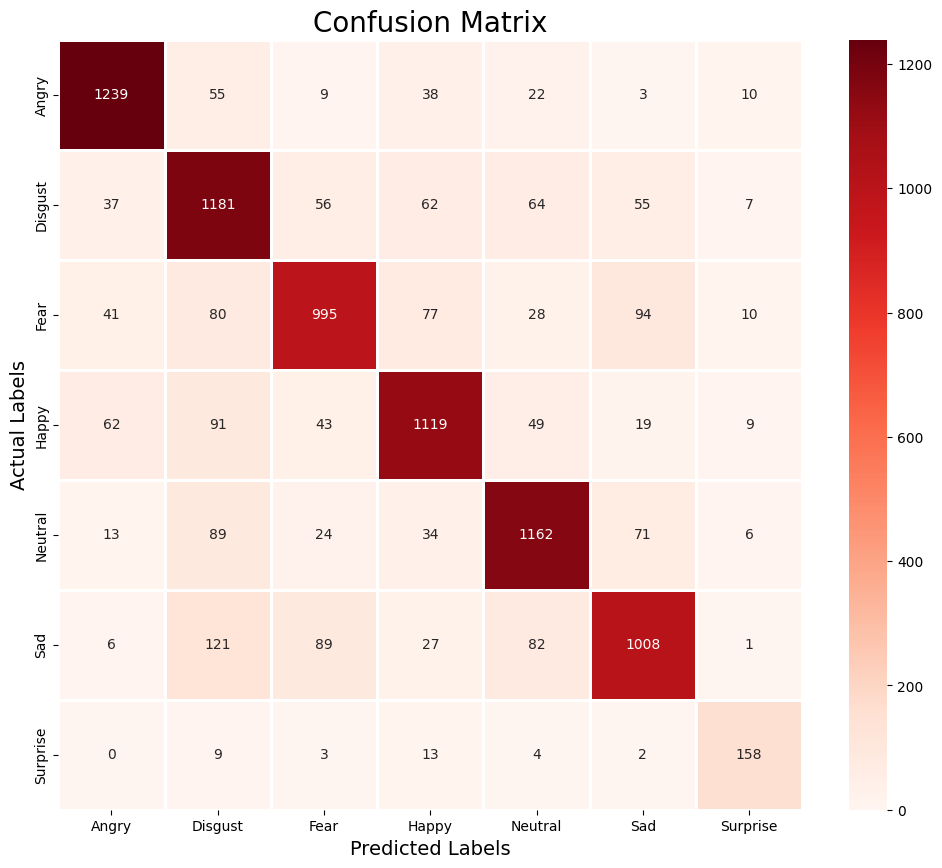

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Reds', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Angry       0.88      0.89      0.88      1376
     Disgust       0.73      0.74      0.74      1462
        Fear       0.81      0.66      0.73      1325
       Happy       0.82      0.77      0.79      1392
     Neutral       0.71      0.85      0.77      1399
         Sad       0.74      0.75      0.74      1334
    Surprise       0.81      0.81      0.81       189

    accuracy                           0.78      8477
   macro avg       0.79      0.78      0.78      8477
weighted avg       0.78      0.78      0.78      8477

